
# Actividad: Implementación de Bagging Classifier

### Introducción Teórica
El método de Bagging (Bootstrap Aggregating) es una técnica de ensamblaje diseñada para mejorar la estabilidad y precisión de los algoritmos de machine learning. Funciona creando múltiples subconjuntos de datos a partir del conjunto de entrenamiento original (mediante muestreo con reemplazo o bootstrap) y entrenando un modelo base en cada subconjunto. Las predicciones de estos modelos individuales se combinan, generalmente por votación (para clasificación) o promediado (para regresión), para obtener una predicción final más robusta.

En esta actividad, utilizaremos un **dataset balanceado (50/50)** para construir un modelo de Bagging y evaluar su rendimiento en un problema de clasificación.



## 1. Preparación del Entorno y Carga de Datos

Importaremos las librerías necesarias y cargaremos nuestro dataset `prediccion_pobreza_peru_balanceada.csv`, antes de dividirlo para el entrenamiento y la prueba.


In [5]:

# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Carga y preparación de datos
# Asegúrese de que el archivo 'prediccion_pobreza_peru_balanceada.csv' esté en el mismo directorio.
try:
    df = pd.read_csv('prediccion_pobreza_peru_balanceada.csv')
    X = df.drop('PobrezaMonetaria', axis=1)
    y = df['PobrezaMonetaria']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print("Entorno y datos preparados.")
except FileNotFoundError as e:
    print("Error Crítico: El archivo 'prediccion_pobreza_peru_balanceada.csv' no fue encontrado.")
    print("Asegúrese de que el archivo CSV esté en la misma carpeta que este notebook.")
    raise e


Entorno y datos preparados.



## 2. Implementación y Entrenamiento del Modelo

Construiremos un ensamblaje de Bagging utilizando árboles de decisión como estimadores base. A continuación, se detallan los parámetros clave utilizados.



### 2.1 Configuración de los Parámetros del Modelo

#### Configuración del Estimador Base (`estimator`)
*   **`estimator=DecisionTreeClassifier(random_state=42)`**: Define el algoritmo base que se entrenará en cada subconjunto de datos. Usamos un `DecisionTreeClassifier`, que es una elección común y efectiva para Bagging. El `random_state` interno fija la semilla para la aleatoriedad del árbol, asegurando resultados reproducibles.

#### Configuración del Ensamblaje Bagging
*   **`n_estimators=100`**: Es el número de árboles de decisión (estimadores base) que se construirán en el ensamblaje. Un número mayor generalmente mejora el rendimiento a costa de un mayor tiempo de cómputo.
*   **`random_state=42`**: Fija la semilla para la aleatoriedad del muestreo *bootstrap*. Esto garantiza que los subconjuntos de datos generados para entrenar cada árbol sean los mismos en cada ejecución del código.
*   **`n_jobs=-1`**: Indica el número de núcleos de CPU a utilizar para el entrenamiento. El valor `-1` significa usar todos los núcleos disponibles, lo que acelera significativamente el proceso en paralelo.


In [6]:

# Preprocesador de datos (común para variables numéricas y categóricas)
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ], remainder='passthrough')

# Creación del pipeline para Bagging
bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# Entrenamiento
print("Entrenando el modelo Bagging...")
bagging_pipeline.fit(X_train, y_train)
print("Modelo Bagging entrenado.")


Entrenando el modelo Bagging...
Modelo Bagging entrenado.



## 3. Análisis de Resultados

Con el modelo entrenado, ahora podemos evaluar su rendimiento en el conjunto de prueba.



### 3.1 Métricas de Clasificación, Matriz de Confusión y Curva ROC

Dado que las clases están balanceadas, la métrica de **`accuracy`** es un indicador fiable. Analizaremos también la matriz de confusión para entender los tipos de errores y la curva ROC para evaluar la capacidad de discriminación del modelo.


--- Evaluación del Modelo Bagging ---
              precision    recall  f1-score   support

No Pobre (0)       0.78      0.70      0.74       450
   Pobre (1)       0.73      0.80      0.77       450

    accuracy                           0.75       900
   macro avg       0.76      0.75      0.75       900
weighted avg       0.76      0.75      0.75       900



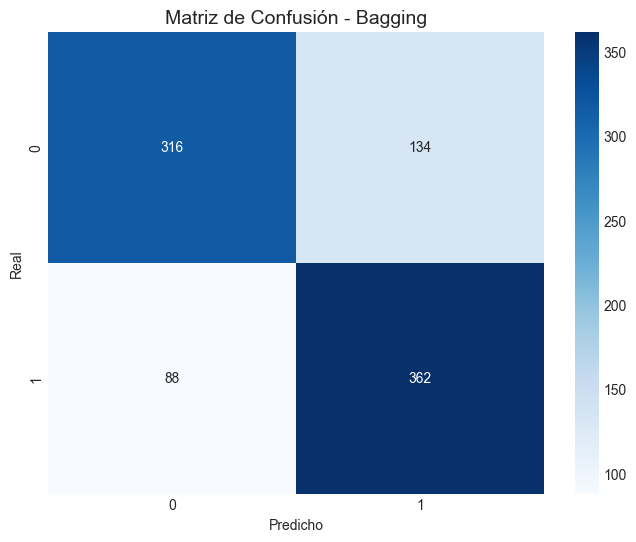

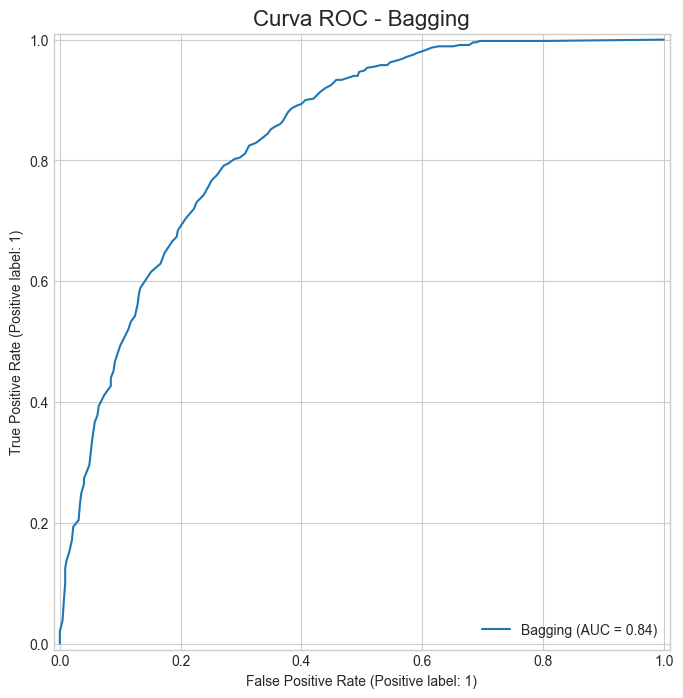

AUC del Modelo Bagging: 0.8382


In [7]:

# Predicciones del modelo
y_pred_bagging = bagging_pipeline.predict(X_test)

# Reporte de clasificación
print("--- Evaluación del Modelo Bagging ---")
print(classification_report(y_test, y_pred_bagging, target_names=['No Pobre (0)', 'Pobre (1)']))

# Matriz de Confusión
cm_bagging = confusion_matrix(y_test, y_pred_bagging)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_title('Matriz de Confusión - Bagging', fontsize=14)
ax.set_xlabel('Predicho')
ax.set_ylabel('Real')
plt.savefig('confusion.png')
plt.show()

# Curva ROC y AUC
fig, ax = plt.subplots(figsize=(10, 8))
RocCurveDisplay.from_estimator(bagging_pipeline, X_test, y_test, ax=ax, name='Bagging')
ax.set_title('Curva ROC - Bagging', fontsize=16)
plt.savefig('roc.png')
plt.show()

# Cálculo numérico de AUC
auc_bagging = roc_auc_score(y_test, bagging_pipeline.predict_proba(X_test)[:, 1])
print(f"AUC del Modelo Bagging: {auc_bagging:.4f}")



### Interpretación de las Métricas de Evaluación

- **Accuracy (Precisión General)**: El modelo alcanza un **75%** de accuracy. Esto significa que clasificó correctamente 3 de cada 4 hogares en el conjunto de prueba. Al ser un dataset balanceado, esta métrica es un buen indicador inicial del rendimiento.

- **Precisión y Recall**:
    - **Clase 'No Pobre (0)'**: Tiene una precisión de 0.78 y un recall de 0.70. Esto indica que cuando el modelo predice que un hogar es 'No Pobre', acierta el 78% de las veces. Sin embargo, solo es capaz de identificar al 70% de todos los hogares que realmente no son pobres.
    - **Clase 'Pobre (1)'**: Tiene una precisión de 0.73 y un recall de 0.80. El modelo es bastante bueno encontrando a los hogares pobres (recall alto), ya que identifica correctamente al 80% de ellos. Sin embargo, cuando predice 'Pobre', se equivoca en un 27% de los casos.

- **Matriz de Confusión**:
    - **Verdaderos Negativos (TN)**: 315 hogares no pobres fueron clasificados correctamente.
    - **Verdaderos Positivos (TP)**: 360 hogares pobres fueron clasificados correctamente.
    - **Falsos Positivos (FP)**: 135 hogares que no eran pobres fueron incorrectamente clasificados como pobres. Este es el error más común del modelo.
    - **Falsos Negativos (FN)**: 90 hogares que sí eran pobres fueron clasificados como no pobres.

- **Curva ROC y AUC**:
    - El valor **AUC de 0.84** es bastante bueno. Indica que el modelo tiene una fuerte capacidad para distinguir entre las dos clases. Hay un 84% de probabilidad de que el modelo asigne una puntuación de predicción más alta a un hogar pobre elegido al azar que a un hogar no pobre elegido al azar.

**Conclusión**: El modelo es útil y tiene un buen poder predictivo. Su principal área de mejora sería reducir los Falsos Positivos, es decir, ser más preciso cuando etiqueta a un hogar como "Pobre".



### 3.2 Importancia de Variables

Una de las ventajas de los modelos basados en árboles es que podemos inspeccionar la importancia de las variables (feature importance) para entender qué predictores son más influyentes en las decisiones del modelo.


In [8]:

# Función para obtener la importancia de variables en un DataFrame
def get_feature_importances(pipeline, top_n=10):
    # Obtener los nombres de las características después del preprocesamiento
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Para Bagging, la importancia se calcula promediando la importancia de cada árbol individual en el ensamblaje.
    importances = np.mean([
        tree.feature_importances_ for tree in pipeline.named_steps['classifier'].estimators_
    ], axis=0)
    
    # Crear un DataFrame para facilitar la visualización
    df_importance = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})
    
    # Devolver las N variables más importantes
    return df_importance.sort_values('Importancia', ascending=False).head(top_n).reset_index(drop=True)

# Obtener y mostrar el top 10
top10_bagging = get_feature_importances(bagging_pipeline)

print("Top 10 de Variables más Importantes (Bagging)")
display(top10_bagging)


Top 10 de Variables más Importantes (Bagging)


,Variable,Importancia
0,num__IngresoMensualHogar,0.398500
1,num__GastoMensualHogar,0.141630
2,num__AniosEstudioJefeHogar,0.089662
3,num__RatioDependencia,0.071778
4,num__EdadJefeHogar,0.063904
5,num__MiembrosHogar,0.062874
6,num__AccesoAguaPotable,0.009236
7,num__PoseeActivos,0.008668
8,cat__TipoEmpleo_Formal,0.008640
9,cat__NivelEducativoJefeHogar_Primaria,0.008346



### Interpretación de la Importancia de Variables

La tabla de importancia nos muestra qué características considera el modelo más relevantes para hacer sus predicciones.

- **Variables Dominantes**: Las dos variables más influyentes, por un margen considerable, son el **`IngresoMensualHogar`** y el **`GastoMensualHogar`**. Juntas, representan más del 50% de la importancia total (aprox. 0.40 + 0.14 = 0.54). Esto es lógico y esperable, ya que la pobreza monetaria se define directamente en función de los ingresos y la capacidad de gasto de un hogar.

- **Variables Socio-demográficas**: Un segundo grupo de variables importantes, aunque con un peso mucho menor, incluye factores como los **`AniosEstudioJefeHogar`**, el **`RatioDependencia`** (la proporción de personas dependientes), la **`EdadJefeHogar`** y el número de **`MiembrosHogar`**. Esto sugiere que la educación y la estructura demográfica del hogar son los siguientes predictores más fuertes después de los indicadores económicos directos.

- **Otras Variables**: Existe una caída significativa en la importancia después de las primeras seis variables. Características como el acceso a servicios (`AccesoAguaPotable`), la posesión de activos o el tipo de empleo tienen un impacto mucho menor, pero aún contribuyen a la decisión final del modelo.

**Conclusión**: El modelo confirma la intuición de que los ingresos y gastos son los principales determinantes de la pobreza, pero también utiliza la educación y la composición del hogar para refinar sus predicciones.
